# 照相机静止不动时的calibration结果处理

## 介绍

3个file：from0，from10，from23三个csv文件，记录的是从三个marker获得的camera_to_base的transformation，

格式为(x,y,z,alpha,beta,gamma)

In [2]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import scipy as sp
import IPython
import pandas as pd
import csv
import cv2

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy import stats


#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 12,8

## ground truth of calibration parameter 

In [4]:
xt = -0.100
yt = 0.87529999
zt = 0.62499994
at = 1.57079633
bt = 0.00
ct = 0.00

## 读入三个csv文件

In [5]:
data_from0 = pd.read_csv("from0.txt",delimiter = " ")
data_from10 = pd.read_csv("from10.txt",delimiter = " ")
data_from23 = pd.read_csv("from23.txt",delimiter = " ")

In [6]:
print(data_from0)

            x         y         z     alpha      beta     gamma
0   -0.104367  0.885310  0.631260  1.580074  0.000891  0.008160
1   -0.095828  0.881758  0.621216  1.566963  0.000107 -0.003086
2   -0.095804  0.881763  0.621175  1.566950  0.000203 -0.003082
3   -0.095779  0.881768  0.621133  1.566936  0.000299 -0.003078
4   -0.095755  0.881773  0.621092  1.566923  0.000396 -0.003074
5   -0.095731  0.881778  0.621051  1.566909  0.000493 -0.003070
6   -0.102798  0.882604  0.614495  1.558282 -0.000075  0.005517
7   -0.102774  0.882609  0.614454  1.558269  0.000022  0.005521
8   -0.102751  0.882614  0.614413  1.558256  0.000119  0.005525
9   -0.102727  0.882619  0.614373  1.558244  0.000217  0.005529
10  -0.102703  0.882624  0.614332  1.558231  0.000314  0.005532
11  -0.102679  0.882629  0.614291  1.558218  0.000411  0.005536
12  -0.102655  0.882633  0.614250  1.558206  0.000509  0.005540
13  -0.102631  0.882638  0.614209  1.558193  0.000607  0.005544
14  -0.102607  0.882643  0.614168  1.558

## 三组数据的分布情况

In [7]:
data_from23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 6 columns):
x        433 non-null float64
y        433 non-null float64
z        433 non-null float64
alpha    433 non-null float64
beta     433 non-null float64
gamma    433 non-null float64
dtypes: float64(6)
memory usage: 20.4 KB


In [8]:
data_from0.describe()

,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.072611,0.643692,0.458397,1.151657,-0.000277,0.000034
std,0.044645,0.390019,0.277729,0.697537,0.002196,0.007242
min,-0.172482,0.000000,0.000000,0.000000,-0.014911,-0.032318
25%,-0.100116,0.000000,0.000000,0.000000,-0.001012,-0.003078
50%,-0.095779,0.879578,0.622524,1.568732,-0.000000,0.000000
75%,0.000000,0.882614,0.627316,1.574824,0.000396,0.002457
max,0.000000,0.891764,0.681156,1.644100,0.022092,0.046263


In [9]:
data_from10.describe()

,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.100670,0.881818,0.624827,1.151657,-0.000277,0.000034
std,0.016079,0.005350,0.015651,0.697537,0.002196,0.007242
min,-0.163900,0.868203,0.544234,0.000000,-0.014911,-0.032318
25%,-0.107449,0.877914,0.616122,0.000000,-0.001012,-0.003078
50%,-0.100561,0.881229,0.624647,1.568732,-0.000000,0.000000
75%,-0.093475,0.885392,0.632851,1.574824,0.000396,0.002457
max,-0.038417,0.901527,0.685559,1.644100,0.022092,0.046263


In [10]:
data_from23.describe()

,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.096510,0.859400,0.610328,1.151657,-0.000277,0.000034
std,0.023793,0.132464,0.095717,0.697537,0.002196,0.007242
min,-0.164644,0.000000,0.000000,0.000000,-0.014911,-0.032318
25%,-0.107365,0.878266,0.613518,0.000000,-0.001012,-0.003078
50%,-0.098397,0.880569,0.624592,1.568732,-0.000000,0.000000
75%,-0.088311,0.882430,0.633977,1.574824,0.000396,0.002457
max,0.000000,0.890282,0.686188,1.644100,0.022092,0.046263


In [11]:
drop_0=data_from0.index[data_from0['x'] == 0].tolist()
c= drop_0
df0=data_from0.drop(data_from0.index[c])
df0.describe()


,x,y,z,alpha,beta,gamma
count,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000
mean,-0.099182,0.879239,0.626138,1.573083,-0.000378,0.000047
std,0.009009,0.014062,0.009285,0.011458,0.002560,0.008467
min,-0.172482,0.778809,0.610620,1.553703,-0.014911,-0.032318
25%,-0.102607,0.878863,0.621094,1.566936,-0.001783,-0.004494
50%,-0.097865,0.881609,0.625074,1.572382,-0.000159,-0.000460
75%,-0.095163,0.883655,0.629630,1.577306,0.000771,0.005530
max,-0.082529,0.891764,0.681156,1.644100,0.022092,0.046263


In [12]:
drop_10=data_from10.index[data_from10['x'] == 0].tolist()
c= drop_10
df10=data_from10.drop(data_from10.index[c])
df10.describe()


,x,y,z,alpha,beta,gamma
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000
mean,-0.100670,0.881818,0.624827,1.151657,-0.000277,0.000034
std,0.016079,0.005350,0.015651,0.697537,0.002196,0.007242
min,-0.163900,0.868203,0.544234,0.000000,-0.014911,-0.032318
25%,-0.107449,0.877914,0.616122,0.000000,-0.001012,-0.003078
50%,-0.100561,0.881229,0.624647,1.568732,-0.000000,0.000000
75%,-0.093475,0.885392,0.632851,1.574824,0.000396,0.002457
max,-0.038417,0.901527,0.685559,1.644100,0.022092,0.046263


In [13]:
drop_23=data_from23.index[data_from23['x'] == 0].tolist()
c= drop_23
df23=data_from23.drop(data_from23.index[c])
df23.describe()

,x,y,z,alpha,beta,gamma
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,-0.098791,0.879716,0.624757,1.167757,-0.000291,0.000044
std,0.018804,0.006865,0.018522,0.688906,0.002202,0.007320
min,-0.164644,0.834900,0.560559,0.000000,-0.014911,-0.032318
25%,-0.107591,0.878453,0.614892,0.000000,-0.001037,-0.003084
50%,-0.098716,0.880613,0.624840,1.569086,-0.000000,0.000000
75%,-0.089594,0.882434,0.634025,1.574987,0.000397,0.002609
max,-0.035732,0.890282,0.686188,1.644100,0.022092,0.046263


## 绘制

In [14]:
print(data_from23['x'])

0     -0.089843
1     -0.089815
2     -0.089787
3     -0.089759
4     -0.089731
5     -0.089703
6     -0.089675
7     -0.089647
8     -0.089619
9     -0.123875
10    -0.123850
11    -0.123824
12    -0.123798
13    -0.123731
14    -0.123701
15    -0.123672
16    -0.123642
17    -0.123612
18    -0.113859
19    -0.102357
20    -0.102363
21    -0.102394
22    -0.102430
23    -0.102455
24    -0.104672
25    -0.072921
26    -0.035732
27    -0.083996
28    -0.123741
29    -0.104705
         ...   
403   -0.103231
404   -0.103175
405   -0.100859
406   -0.140720
407   -0.120706
408   -0.100744
409   -0.078973
410   -0.068321
411   -0.056869
412   -0.095062
413   -0.134612
414   -0.090429
415   -0.100349
416   -0.102494
417   -0.089690
418   -0.098397
419   -0.082445
420   -0.090182
421   -0.070455
422   -0.093934
423   -0.108263
424   -0.132112
425   -0.135090
426   -0.099764
427   -0.103995
428   -0.114351
429   -0.077287
430   -0.141546
431   -0.068708
432   -0.097806
Name: x, Length: 433, dt

In [15]:
print(df10['x'])

0     -0.099641
1     -0.099643
2     -0.099645
3     -0.099646
4     -0.099648
5     -0.099650
6     -0.099651
7     -0.099652
8     -0.099653
9     -0.099655
10    -0.111852
11    -0.111848
12    -0.111844
13    -0.111841
14    -0.111837
15    -0.111833
16    -0.105009
17    -0.105008
18    -0.105007
19    -0.091475
20    -0.091505
21    -0.085261
22    -0.085322
23    -0.085372
24    -0.085400
25    -0.080896
26    -0.108017
27    -0.085129
28    -0.097391
29    -0.103028
         ...   
403   -0.083739
404   -0.083668
405   -0.109919
406   -0.116088
407   -0.090973
408   -0.100440
409   -0.108587
410   -0.075253
411   -0.114993
412   -0.092745
413   -0.105280
414   -0.091635
415   -0.088629
416   -0.108495
417   -0.107535
418   -0.091086
419   -0.093475
420   -0.106575
421   -0.096169
422   -0.072899
423   -0.114000
424   -0.104366
425   -0.103707
426   -0.100954
427   -0.105866
428   -0.105932
429   -0.115223
430   -0.113357
431   -0.082347
432   -0.078110
Name: x, Length: 433, dt

## 通过marker0获得，marker0在link4上

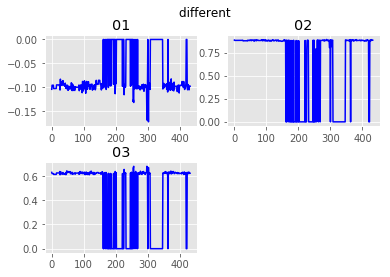

In [16]:
x = data_from0['x']
y = data_from0['y']
z = data_from0['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x, color='blue')
ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y, color='blue')
ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z, color='blue')

### 去零

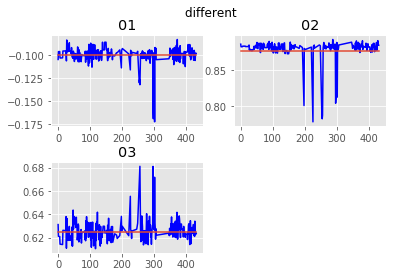

In [17]:
x0 = df0['x']
y0 = df0['y']
z0 = df0['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x0, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y0, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z0, color='blue')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 通过marker23获得，在link6上

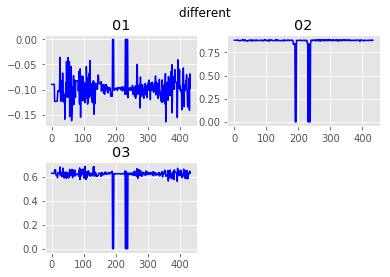

In [18]:
x = data_from23['x']
y = data_from23['y']
z = data_from23['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x, color='blue')
ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y, color='blue')
ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z, color='blue')

### 去零

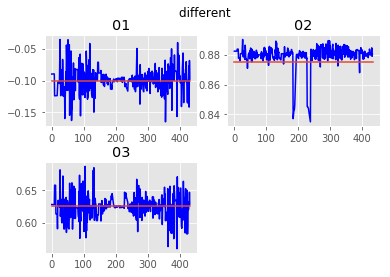

In [19]:
x23 = df23['x']
y23 = df23['y']
z23 = df23['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x23, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y23, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z23, color='blue')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 通过marker10获得，位于link8上

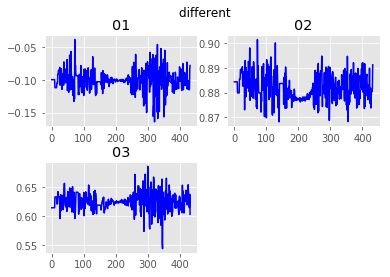

In [20]:
x = data_from10['x']
y = data_from10['y']
z = data_from10['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x, color='blue')
ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y, color='blue')
ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z, color='blue')


### 去零

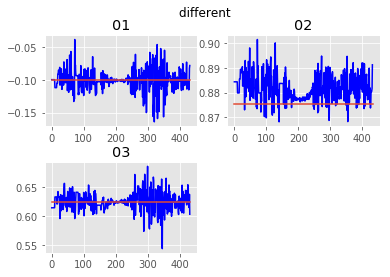

In [21]:
x10 = df10['x']
y10 = df10['y']
z10 = df10['z']

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x10, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y10, color='blue')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z10, color='blue')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 去零后汇总

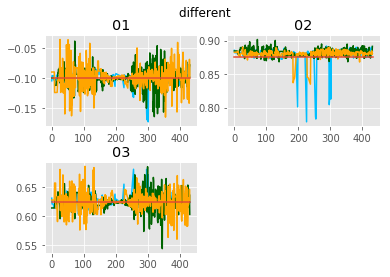

In [22]:
fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x0, color='deepskyblue')
ax221.plot(x10, color='darkgreen')
ax221.plot(x23, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y0, color='deepskyblue')
ax222.plot(y10, color='darkgreen')
ax222.plot(y23, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z0, color='deepskyblue')
ax223.plot(z10, color='darkgreen')
ax223.plot(z23, color='orange')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## 卡尔曼滤波器

### use kf on marker10

In [86]:
# 6: x, y, z, dx, dy, dz; 3: observe conditions
kalman_pos = cv2.KalmanFilter(6, 3) 
# 6: a, b, c, da, db, dc; 3: observe conditions
kalman_ori = cv2.KalmanFilter(6, 3) 

# measurement matrix
kalman_pos.measurementMatrix= np.array([[1, 0, 0, 0, 0, 0], 
                                        [0, 1, 0, 0, 0, 0], 
                                        [0, 0, 1, 0, 0, 0]], np.float32)
kalman_ori.measurementMatrix= np.array([[1, 0, 0, 0, 0, 0], 
                                        [0, 1, 0, 0, 0, 0], 
                                        [0, 0, 1, 0, 0, 0]], np.float32)
# zhuangtaizhuanyi matrix
kalman_pos.transitionMatrix = np.array([[1, 0, 0, 1, 0, 0], 
                                    [0, 1, 0, 0, 1, 0], 
                                    [0, 0, 1, 0, 0, 1], 
                                    [0, 0, 0, 1, 0, 0], 
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1],], np.float32)
kalman_ori.transitionMatrix = np.array([[1, 0, 0, 1, 0, 0], 
                                    [0, 1, 0, 0, 1, 0], 
                                    [0, 0, 1, 0, 0, 1], 
                                    [0, 0, 0, 1, 0, 0], 
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1],], np.float32)

# noise covariance
kalman_pos.processNoiseCov = np.array([ [1, 0, 0, 0, 0, 0], 
                                    [0, 1, 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, 1, 0, 0],
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1]], np.float32)*1e-3
kalman_ori.processNoiseCov = np.array([ [1, 0, 0, 0, 0, 0], 
                                    [0, 1, 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, 1, 0, 0],
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1]], np.float32)*1e-5

# initalize measurement and predictions

In [100]:
# initalize measurement and predictions
last_measurement_pos = current_measurement_pos = (data_from10['x'][0],data_from10['y'][0],data_from10['z'][0])
last_prediction_pos = current_prediction_pos = (data_from10['x'][0],data_from10['y'][0],data_from10['z'][0])

last_measurement_ori = current_measurement_ori = (data_from10['alpha'][0],data_from10['beta'][0],data_from10['gamma'][0])
last_prediction_ori = current_prediction_ori = (data_from10['alpha'][0],data_from10['beta'][0],data_from10['gamma'][0])

## kalman filter section

In [103]:
def kalman_filter(position,orientation):  
    
    global current_measurement_pos, last_measurement_pos, current_prediction_pos, last_prediction_pos
    global current_measurement_ori, last_measurement_ori, current_prediction_ori, last_prediction_ori
    # save current prediction as last prediction
    last_prediction_pos = current_prediction_pos 
    last_prediction_ori = current_prediction_ori 
    # save current measurement as last measurement
    last_measurement_pos = current_measurement_pos
    last_measurement_ori = current_measurement_ori
    x = position[0]
    y = position[1]
    z = position[2]
    euler = (orientation[0],orientation[1],orientation[2])
    print("orientation: ", euler)
    # rxyz: rotational axis; sxyz: static axis
   # angle = tf.transformations.euler_from_quaternion(quat,'sxyz')
   # quat2 = tf.transformations.quaternion_from_euler(quat,'sxyz')
   # print("angles: ", a, b, c)
 #   print(x)
    
    # current_measurement
    current_measurement_pos = np.array([[np.float32(x)], [np.float32(y)], [np.float32(z)]]) 
  #  current_measurement_ori = np.array([[np.float32(a)], [np.float32(b)], [np.float32(c)]]) 
 #   print(current_measurement)

    # correction phase
    kalman_pos.correct(current_measurement_pos) 
 #   kalman_ori.correct(current_measurement_ori) 
    # current kalman prediction
    current_prediction_pos = kalman_pos.predict() 
 #   current_prediction_ori = kalman_ori.predict() 
    
 #   print(x)
    print(current_prediction_pos)
 #   print("prediction: ", current_prediction)
    return current_prediction_pos, orientation

In [104]:
filtered_pos_array = np.zeros((len(data_from10['x']),3))

In [105]:
for i in range (0,len(data_from10['x'])):
    pos=(data_from10['x'][i],data_from10['y'][i],data_from10['z'][i])
    ori=(data_from10['alpha'][i],data_from10['beta'][i],data_from10['gamma'][i])
    filtered_pos, filtered_ori = kalman_filter(pos,ori)
    filtered_pos_array[i][0] = filtered_pos[0]
    filtered_pos_array[i][1] = filtered_pos[1]
    filtered_pos_array[i][2] = filtered_pos[2]
    

('orientation: ', (1.5800738138930404, 0.000891133855812274, 0.008160112054291365))
[[-9.7707778e-02]
 [ 8.8292199e-01]
 [ 6.2049717e-01]
 [ 3.7301431e-04]
 [ 2.9092608e-04]
 [-1.0462996e-03]]
('orientation: ', (1.5669629837321566, 0.00010659887186336991, -0.003085962504201181))
[[-9.7822450e-02]
 [ 8.8358462e-01]
 [ 6.1790931e-01]
 [ 3.1910866e-04]
 [ 3.3201202e-04]
 [-1.2166932e-03]]
('orientation: ', (1.5669496011372217, 0.00020320319196781133, -0.0030819885352623925))
[[-9.7962558e-02]
 [ 8.8412130e-01]
 [ 6.1580765e-01]
 [ 2.6835082e-04]
 [ 3.5463111e-04]
 [-1.3145094e-03]]
('orientation: ', (1.5669361346519135, 0.00029947079010551094, -0.0030780966122864665))
[[-9.8118544e-02]
 [ 8.8454521e-01]
 [ 6.1414212e-01]
 [ 2.2144784e-04]
 [ 3.6228812e-04]
 [-1.3533075e-03]]
('orientation: ', (1.5669226679751265, 0.00039637903588413576, -0.0030737302625287503))
[[-9.8282449e-02]
 [ 8.8486981e-01]
 [ 6.1286187e-01]
 [ 1.7885421e-04]
 [ 3.5812589e-04]
 [-1.3452354e-03]]
('orientation: ', (1

[[-1.1190082e-01]
 [ 8.7823230e-01]
 [ 6.2705332e-01]
 [-1.3161121e-03]
 [-4.3463625e-04]
 [ 5.4231111e-04]]
('orientation: ', (1.5690782215670835, -0.0015914657704147893, -0.017737685907810836))
[[-1.1117681e-01]
 [ 8.7851501e-01]
 [ 6.2614787e-01]
 [-1.0906121e-03]
 [-3.5534659e-04]
 [ 3.8228239e-04]]
('orientation: ', (1.573055143971979, -0.00022625039392312383, -0.008022268133657405))
[[-1.1471065e-01]
 [ 8.7556094e-01]
 [ 6.2096685e-01]
 [-1.3606695e-03]
 [-6.4258941e-04]
 [-2.3264505e-04]]
('orientation: ', (1.5773625429839488, -0.0011509205024392436, -0.006779224666204074))
[[-1.1299025e-01]
 [ 8.7696528e-01]
 [ 6.2024343e-01]
 [-1.0201095e-03]
 [-4.1633542e-04]
 [-2.8689500e-04]]
('orientation: ', (1.5772772700610385, -0.0011396811541049036, -0.006611805313120304))
[[-1.1141323e-01]
 [ 8.7826085e-01]
 [ 6.1962628e-01]
 [-7.3304097e-04]
 [-2.2711637e-04]
 [-3.2339533e-04]]
('orientation: ', (1.5773061787246676, -0.0010950816291179174, -0.006566228042318947))
[[-1.0995737e-01]
 [

('orientation: ', (1.566635919600324, -0.00014855857969778256, 0.0033843925013031808))
[[-9.9002659e-02]
 [ 8.8217258e-01]
 [ 6.1668128e-01]
 [ 1.1172733e-04]
 [-2.4811833e-04]
 [-1.9973591e-03]]
('orientation: ', (1.5624750782136854, 0.0012110470868618242, -0.005246112148394274))
[[-9.4487056e-02]
 [ 8.8342947e-01]
 [ 6.2195957e-01]
 [ 5.9850118e-04]
 [-8.1767415e-05]
 [-1.1931611e-03]]
('orientation: ', (1.55881068446556, 0.0019541535263961607, 0.008288163368947714))
[[-9.6523084e-02]
 [ 8.8231975e-01]
 [ 6.2020254e-01]
 [ 3.0729908e-04]
 [-1.9538916e-04]
 [-1.2554865e-03]]
('orientation: ', (1.5827664624472535, -0.002782565783141921, -0.003749161978535275))
[[-9.7249545e-02]
 [ 8.8165569e-01]
 [ 6.2050420e-01]
 [ 1.9303379e-04]
 [-2.4719525e-04]
 [-1.0833680e-03]]
('orientation: ', (1.5735143901721331, 0.0002002199073167206, 0.002625244811415541))
[[-1.0434476e-01]
 [ 8.8044584e-01]
 [ 6.2759912e-01]
 [-6.1255816e-04]
 [-3.5360159e-04]
 [-1.7939633e-04]]
('orientation: ', (1.5738942

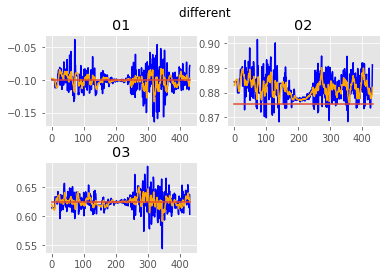

In [107]:
x10 = df10['x']
y10 = df10['y']
z10 = df10['z']
xf10 = filtered_pos_array[:,0]
yf10 = filtered_pos_array[:,1]
zf10 = filtered_pos_array[:,2]

fig = plt.figure()
fig.suptitle('different ')
fig.subplots_adjust(hspace=0.4)

ax221 = fig.add_subplot(221)  
ax221.set_title('01')
ax221.plot(x10, color='blue')
ax221.plot(xf10, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [xt, xt]
ax221.plot(x_coordinates, y_coordinates)

ax222 = fig.add_subplot(222)
ax222.set_title('02')
ax222.plot(y10, color='blue')
ax222.plot(yf10, color='orange')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [yt, yt]
ax222.plot(x_coordinates, y_coordinates)

ax223 = fig.add_subplot(223)
ax223.set_title('03')
ax223.plot(z10, color='blue')
ax223.plot(zf10, color='orange')
ax223.plot(zt,color='red')
x_coordinates = [0,len(data_from0['x'])]
y_coordinates = [zt, zt]
ax223.plot(x_coordinates, y_coordinates)

## user on marker 23

In [109]:
# 6: x, y, z, dx, dy, dz; 3: observe conditions
kalman_pos = cv2.KalmanFilter(6, 3) 
# 6: a, b, c, da, db, dc; 3: observe conditions
kalman_ori = cv2.KalmanFilter(6, 3) 

# measurement matrix
kalman_pos.measurementMatrix= np.array([[1, 0, 0, 0, 0, 0], 
                                        [0, 1, 0, 0, 0, 0], 
                                        [0, 0, 1, 0, 0, 0]], np.float32)
kalman_ori.measurementMatrix= np.array([[1, 0, 0, 0, 0, 0], 
                                        [0, 1, 0, 0, 0, 0], 
                                        [0, 0, 1, 0, 0, 0]], np.float32)
# zhuangtaizhuanyi matrix
kalman_pos.transitionMatrix = np.array([[1, 0, 0, 1, 0, 0], 
                                    [0, 1, 0, 0, 1, 0], 
                                    [0, 0, 1, 0, 0, 1], 
                                    [0, 0, 0, 1, 0, 0], 
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1],], np.float32)
kalman_ori.transitionMatrix = np.array([[1, 0, 0, 1, 0, 0], 
                                    [0, 1, 0, 0, 1, 0], 
                                    [0, 0, 1, 0, 0, 1], 
                                    [0, 0, 0, 1, 0, 0], 
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1],], np.float32)

# noise covariance
kalman_pos.processNoiseCov = np.array([ [1, 0, 0, 0, 0, 0], 
                                    [0, 1, 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, 1, 0, 0],
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1]], np.float32)*1e-3
kalman_ori.processNoiseCov = np.array([ [1, 0, 0, 0, 0, 0], 
                                    [0, 1, 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, 1, 0, 0],
                                    [0, 0, 0, 0, 1, 0],
                                    [0, 0, 0, 0, 0, 1]], np.float32)*1e-5

In [111]:
# initalize measurement and predictions
last_measurement_pos = current_measurement_pos = (data_from23['x'][0],data_from23['y'][0],data_from23['z'][0])
last_prediction_pos = current_prediction_pos = (data_from23['x'][0],data_from23['y'][0],data_from23['z'][0])

last_measurement_ori = current_measurement_ori = (data_from23['alpha'][0],data_from23['beta'][0],data_from23['gamma'][0])
last_prediction_ori = current_prediction_ori = (data_from23['alpha'][0],data_from23['beta'][0],data_from23['gamma'][0])

In [112]:
def kalman_filter(position,orientation):  
    
    global current_measurement_pos, last_measurement_pos, current_prediction_pos, last_prediction_pos
    global current_measurement_ori, last_measurement_ori, current_prediction_ori, last_prediction_ori
    # save current prediction as last prediction
    last_prediction_pos = current_prediction_pos 
    last_prediction_ori = current_prediction_ori 
    # save current measurement as last measurement
    last_measurement_pos = current_measurement_pos
    last_measurement_ori = current_measurement_ori
    x = position[0]
    y = position[1]
    z = position[2]
    euler = (orientation[0],orientation[1],orientation[2])
    print("orientation: ", euler)
    # rxyz: rotational axis; sxyz: static axis
   # angle = tf.transformations.euler_from_quaternion(quat,'sxyz')
   # quat2 = tf.transformations.quaternion_from_euler(quat,'sxyz')
   # print("angles: ", a, b, c)
 #   print(x)
    
    # current_measurement
    current_measurement_pos = np.array([[np.float32(x)], [np.float32(y)], [np.float32(z)]]) 
  #  current_measurement_ori = np.array([[np.float32(a)], [np.float32(b)], [np.float32(c)]]) 
 #   print(current_measurement)

    # correction phase
    kalman_pos.correct(current_measurement_pos) 
 #   kalman_ori.correct(current_measurement_ori) 
    # current kalman prediction
    current_prediction_pos = kalman_pos.predict() 
 #   current_prediction_ori = kalman_ori.predict() 
    
 #   print(x)
    print(current_prediction_pos)
 #   print("prediction: ", current_prediction)
    return current_prediction_pos, orientation